# Function Testing Notebook - Matrix Difference Plot

This notebook is meant to test external-facing functions to ensure they are working as expected.

A dedicated test_all_functions.py with unit testing might be better, but this is a good benchmark

In [1]:
import os
import sys
from pathlib import Path
import time
import tempfile
import logging

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import mne
from dask_jobqueue import SLURMCluster
from dask.distributed import Client, LocalCluster

In [2]:
packageroot = Path('../../').resolve()
# packageroot = Path('/home/dongjp/source-code/PyEEG').resolve()
print(packageroot)
sys.path.append(str(packageroot))

from pythoneeg import core
from pythoneeg import visualization
from pythoneeg import constants

print(core.__all__)
# print(visualization.__all__)
# print(dir(constants))

/home/dongjp/source-code/PyEEG


/home/dongjp/source-code/PyEEG/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


['DDFBinaryMetadata', 'LongRecordingOrganizer', 'convert_ddfcolbin_to_ddfrowbin', 'convert_ddfrowbin_to_si', 'convert_units_to_multiplier', 'convert_colpath_to_rowpath', 'filepath_to_index', 'is_day', 'set_temp_directory', 'get_temp_directory', 'parse_path_to_animalday', 'parse_path_to_genotype', 'parse_path_to_animal', 'parse_path_to_day', 'parse_chname_to_abbrev', 'nanaverage', 'LongRecordingAnalyzer', 'MountainSortAnalyzer', 'FragmentAnalyzer', '_log_transform']


In [3]:
# core.set_temp_directory('/scr1/users/dongjp')
core.set_temp_directory(Path('../../tmp/').resolve())
core.get_temp_directory()

PosixPath('/home/dongjp/source-code/PyEEG/tmp')

## Test WAR

In [4]:
animal_ids = ['A10', 'F22']
base_folder = Path('./test-data').resolve()
wars = []

for animal_id in animal_ids:
    ao = visualization.AnimalOrganizer(base_folder, animal_id, mode="concat", assume_from_number=True)
    ao.convert_colbins_to_rowbins(overwrite=False)
    ao.convert_rowbins_to_rec(multiprocess_mode='serial')

    war = ao.compute_windowed_analysis(['all'], multiprocess_mode='serial')
    # war.to_pickle_and_json(Path(f'./test-wars/{animal_id}').resolve())

    sars = ao.compute_spike_analysis(multiprocess_mode='serial')
    raws = []
    for sar in sars:
        raws.append(sar.convert_to_mne())

    war.read_sars_spikes(sars)
    wars.append(war)

ep = visualization.ExperimentPlotter(wars)


Processing rows:  97%|█████████▋| 30/31 [00:03<00:00,  7.87it/s]/home/dongjp/source-code/PyEEG/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:790: UserWarning: nperseg = 1000 is greater than input length  = 360, using nperseg = 360
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/home/dongjp/source-code/PyEEG/pythoneeg/core/analyze_frag.py:293: UserWarning: At least one of the wavelets (91) is longer than the signal (90). Consider using a longer signal or shorter wavelets.
  con = spectral_connectivity_time(rec_mne,
/home/dongjp/source-code/PyEEG/.venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:790: UserWarning: nperseg = 1000 is greater than input length  = 360, using nperseg = 360
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
Processing rows: 100%|██████████| 31/31 [00:03<00:00,  7.85it/s]


Channel names: 	['Intan Input (1)/PortC C-009', 'Intan Input (1)/PortC C-010', 'Intan Input (1)/PortC C-012', 'Intan Input (1)/PortC C-014', 'Intan Input (1)/PortC C-015', 'Intan Input (1)/PortC C-016', 'Intan Input (1)/PortC C-017', 'Intan Input (1)/PortC C-019', 'Intan Input (1)/PortC C-021', 'Intan Input (1)/PortC C-022']
Channel abbreviations: 	['LAud', 'LVis', 'LHip', 'LBar', 'LMot', 'RMot', 'RBar', 'RHip', 'RVis', 'RAud']


write_binary_recording (no parallelization): 100%|██████████| 3/3 [00:00<00:00, 39.52it/s]


Creating RawArray with float64 data, n_channels=10, n_times=120360
    Range : 0 ... 120359 =      0.000 ...   120.359 secs
Ready.


Processing rows:  99%|█████████▉| 116/117 [00:13<00:00,  8.91it/s]/home/dongjp/source-code/PyEEG/pythoneeg/core/analyze_frag.py:293: UserWarning: At least one of the wavelets (611) is longer than the signal (610). Consider using a longer signal or shorter wavelets.
  con = spectral_connectivity_time(rec_mne,
Processing rows: 100%|██████████| 117/117 [00:13<00:00,  8.51it/s]


Channel names: 	['Intan Input (1)/PortD D-009', 'Intan Input (1)/PortD D-010', 'Intan Input (1)/PortD D-012', 'Intan Input (1)/PortD D-014', 'Intan Input (1)/PortD D-015', 'Intan Input (1)/PortD D-016', 'Intan Input (1)/PortD D-017', 'Intan Input (1)/PortD D-019', 'Intan Input (1)/PortD D-021', 'Intan Input (1)/PortD D-022']
Channel abbreviations: 	['LAud', 'LVis', 'LHip', 'LBar', 'LMot', 'RMot', 'RBar', 'RHip', 'RVis', 'RAud']


write_binary_recording (no parallelization): 100%|██████████| 8/8 [00:00<00:00, 29.03it/s]


Creating RawArray with float64 data, n_channels=10, n_times=466440
    Range : 0 ... 466439 =      0.000 ...   466.439 secs
Ready.


In [5]:
for feat in constants.LINEAR_FEATURES:
    if feat == 'nspike':
        logging.info("skipping nspike")
        continue
    logging.info(f'pulling {feat}')
    df = ep.pull_timeseries_dataframe(feat, ['genotype','animalday'])
    display(df)

df2 = ep.pull_timeseries_dataframe('rms', ['genotype','animal'], collapse_channels=True)
display(df2)

,genotype,animalday,channel,rms
0,KO,A10 KO Dec-13-2023,LAud,45.943680
1,KO,A10 KO Dec-13-2023,LAud,17.386600
2,KO,A10 KO Dec-13-2023,LAud,21.215878
3,KO,A10 KO Dec-13-2023,LAud,16.124065
4,KO,A10 KO Dec-13-2023,LAud,18.514662
...,...,...,...,...
1475,KO,F22 KO Dec-12-2023,RVis,190.791611
1476,KO,F22 KO Dec-12-2023,RVis,190.507706
1477,KO,F22 KO Dec-12-2023,RVis,182.628235
1478,KO,F22 KO Dec-12-2023,RVis,200.539948


,genotype,animalday,channel,ampvar
0,KO,A10 KO Dec-13-2023,LAud,2109.176025
1,KO,A10 KO Dec-13-2023,LAud,300.913330
2,KO,A10 KO Dec-13-2023,LAud,448.868134
3,KO,A10 KO Dec-13-2023,LAud,258.858398
4,KO,A10 KO Dec-13-2023,LAud,342.501068
...,...,...,...,...
1475,KO,F22 KO Dec-12-2023,RVis,36401.070312
1476,KO,F22 KO Dec-12-2023,RVis,36271.769531
1477,KO,F22 KO Dec-12-2023,RVis,33343.859375
1478,KO,F22 KO Dec-12-2023,RVis,40216.011719


,genotype,animalday,channel,psdtotal
0,KO,A10 KO Dec-13-2023,LAud,2147.503012
1,KO,A10 KO Dec-13-2023,LAud,207.682113
2,KO,A10 KO Dec-13-2023,LAud,350.046987
3,KO,A10 KO Dec-13-2023,LAud,205.491648
4,KO,A10 KO Dec-13-2023,LAud,243.023354
...,...,...,...,...
1475,KO,F22 KO Dec-12-2023,RVis,27197.533522
1476,KO,F22 KO Dec-12-2023,RVis,32007.720071
1477,KO,F22 KO Dec-12-2023,RVis,29728.320429
1478,KO,F22 KO Dec-12-2023,RVis,35940.778162


,genotype,animalday,channel,psdslope
0,KO,A10 KO Dec-13-2023,LAud,-2.518597
1,KO,A10 KO Dec-13-2023,LAud,-1.943868
2,KO,A10 KO Dec-13-2023,LAud,-2.027279
3,KO,A10 KO Dec-13-2023,LAud,-1.880628
4,KO,A10 KO Dec-13-2023,LAud,-1.994433
...,...,...,...,...
1475,KO,F22 KO Dec-12-2023,RVis,-1.009639
1476,KO,F22 KO Dec-12-2023,RVis,-0.567429
1477,KO,F22 KO Dec-12-2023,RVis,-0.779695
1478,KO,F22 KO Dec-12-2023,RVis,-0.776413


,genotype,animalday,channel,logrms
0,KO,A10 KO Dec-13-2023,LAud,3.848948
1,KO,A10 KO Dec-13-2023,LAud,2.911622
2,KO,A10 KO Dec-13-2023,LAud,3.100807
3,KO,A10 KO Dec-13-2023,LAud,2.840485
4,KO,A10 KO Dec-13-2023,LAud,2.971166
...,...,...,...,...
1475,KO,F22 KO Dec-12-2023,RVis,5.256410
1476,KO,F22 KO Dec-12-2023,RVis,5.254928
1477,KO,F22 KO Dec-12-2023,RVis,5.212914
1478,KO,F22 KO Dec-12-2023,RVis,5.305988


,genotype,animalday,channel,logampvar
0,KO,A10 KO Dec-13-2023,LAud,7.654527
1,KO,A10 KO Dec-13-2023,LAud,5.710140
2,KO,A10 KO Dec-13-2023,LAud,6.108954
3,KO,A10 KO Dec-13-2023,LAud,5.560137
4,KO,A10 KO Dec-13-2023,LAud,5.839190
...,...,...,...,...
1475,KO,F22 KO Dec-12-2023,RVis,10.502381
1476,KO,F22 KO Dec-12-2023,RVis,10.498822
1477,KO,F22 KO Dec-12-2023,RVis,10.414659
1478,KO,F22 KO Dec-12-2023,RVis,10.602045


,genotype,animalday,channel,logpsdtotal
0,KO,A10 KO Dec-13-2023,LAud,7.672527
1,KO,A10 KO Dec-13-2023,LAud,5.340812
2,KO,A10 KO Dec-13-2023,LAud,5.860920
3,KO,A10 KO Dec-13-2023,LAud,5.330260
4,KO,A10 KO Dec-13-2023,LAud,5.497264
...,...,...,...,...
1475,KO,F22 KO Dec-12-2023,RVis,10.210918
1476,KO,F22 KO Dec-12-2023,RVis,10.373764
1477,KO,F22 KO Dec-12-2023,RVis,10.299889
1478,KO,F22 KO Dec-12-2023,RVis,10.489656


,genotype,animalday,channel,lognspike
0,KO,A10 KO Dec-13-2023,LAud,0.0
1,KO,A10 KO Dec-13-2023,LAud,0.0
2,KO,A10 KO Dec-13-2023,LAud,0.0
3,KO,A10 KO Dec-13-2023,LAud,0.0
4,KO,A10 KO Dec-13-2023,LAud,0.0
...,...,...,...,...
1475,KO,F22 KO Dec-12-2023,RVis,0.0
1476,KO,F22 KO Dec-12-2023,RVis,0.0
1477,KO,F22 KO Dec-12-2023,RVis,0.0
1478,KO,F22 KO Dec-12-2023,RVis,0.0


,genotype,animal,channel,rms
0,KO,A10,average,64.171074
1,KO,A10,average,68.034317
2,KO,A10,average,72.459282
3,KO,A10,average,66.441269
4,KO,A10,average,69.594780
...,...,...,...,...
143,KO,F22,average,232.900146
144,KO,F22,average,414.066833
145,KO,F22,average,307.385376
146,KO,F22,average,310.215759


In [6]:
logging.basicConfig(format='%(asctime)s - %(levelname)s - %(message)s', level=logging.DEBUG, stream=sys.stdout, force=True)
logger = logging.getLogger()

In [7]:
# g = ep.plot_catplot('psdband', ['animal'], 
#                     collapse_channels=False, hue='channel', col='band',
#                     # stat_pairs='x',
#                     # stat_pairs=[[('A10 KO Dec-13-2023', 'theta'), ('F22 KO Dec-12-2023', 'delta')]],
#                     # stat_pairs=[[('F22', 'delta'), ('F22', 'theta')], [('F22', 'theta'), ('A10', 'theta')]], 
#                     # stat_pairs=[[('F22', 'delta'), ('F22', 'theta')], [('F22', 'theta'), ('A10', 'theta')]], 
#                     # stat_pairs=perms,
#                     # stat_test='Brunner-Munzel',
#                     # norm_test='log-D-Agostino',
#                     )

2025-04-10 17:38:38,438 - DEBUG - groups: [('A10 KO Dec-13-2023', 'KO'), ('F22 KO Dec-12-2023', 'KO')]
2025-04-10 17:38:38,440 - DEBUG - vals.shape: (31, 5, 10, 10)
2025-04-10 17:38:38,441 - DEBUG - vals.shape: (31, 5, 10, 10)
2025-04-10 17:38:38,445 - DEBUG - vals.shape: (117, 5, 10, 10)
2025-04-10 17:38:38,446 - DEBUG - vals.shape: (117, 5, 10, 10)


2025-04-10 17:38:38,459 - DEBUG - groupby_cols: ['animalday', 'genotype', 'channel', 'band']
2025-04-10 17:38:38,469 - DEBUG - Groupby: ['animalday', 'genotype']
2025-04-10 17:38:38,470 - DEBUG - Baseline groupby: ['animalday', 'genotype']
2025-04-10 17:38:38,470 - DEBUG - Baseline key: ('A10 KO Dec-13-2023', 'KO')
2025-04-10 17:38:38,471 - DEBUG - Remaining groupby: []
2025-04-10 17:38:38,504 - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-04-10 17:38:38,505 - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-04-10 17:38:38,509 - DEBUG - findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2025-04-10 17:38:38,511 - DEBUG - findfont: score(FontEntry(fname='/home/dongjp/source-code/PyEEG/.venv/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFourSymReg.ttf', name='STIXSizeFourSym', style='normal', variant='normal', weight=400, stretch='normal', siz

,genotype,channel,cohere,band
0,KO,all,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",delta
1,KO,all,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",theta
2,KO,all,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",alpha
3,KO,all,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",beta
4,KO,all,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",gamma
...,...,...,...,...
735,KO,all,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",delta
736,KO,all,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",theta
737,KO,all,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",alpha
738,KO,all,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",beta


2025-04-10 17:38:40,167 - DEBUG - groups: [('A10 KO Dec-13-2023', 'KO'), ('F22 KO Dec-12-2023', 'KO')]
2025-04-10 17:38:40,169 - DEBUG - vals.shape: (31, 5, 10, 10)
2025-04-10 17:38:40,169 - DEBUG - vals.shape: (31, 5, 10, 10)
2025-04-10 17:38:40,172 - DEBUG - vals.shape: (117, 5, 10, 10)
2025-04-10 17:38:40,173 - DEBUG - vals.shape: (117, 5, 10, 10)
2025-04-10 17:38:40,184 - DEBUG - groupby_cols: ['animalday', 'genotype', 'channel', 'band']
2025-04-10 17:38:40,260 - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7f72e8f9f940>


,animalday,genotype,channel,band,cohere
0,A10 KO Dec-13-2023,KO,all,alpha,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,A10 KO Dec-13-2023,KO,all,beta,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,A10 KO Dec-13-2023,KO,all,delta,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,A10 KO Dec-13-2023,KO,all,gamma,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,A10 KO Dec-13-2023,KO,all,theta,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
5,F22 KO Dec-12-2023,KO,all,alpha,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
6,F22 KO Dec-12-2023,KO,all,beta,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
7,F22 KO Dec-12-2023,KO,all,delta,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
8,F22 KO Dec-12-2023,KO,all,gamma,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
9,F22 KO Dec-12-2023,KO,all,theta,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


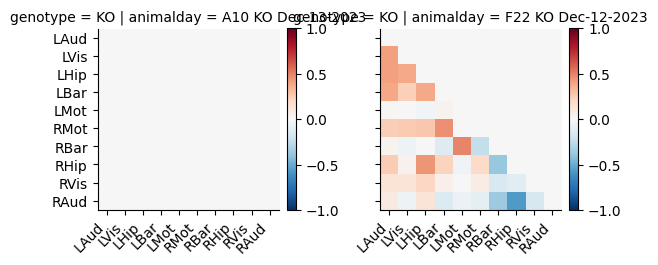

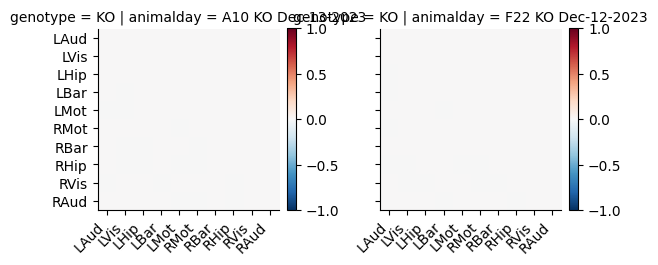

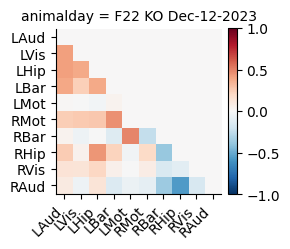

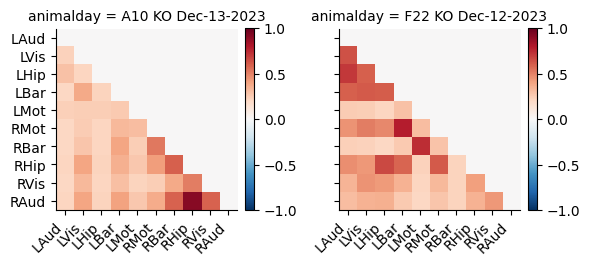

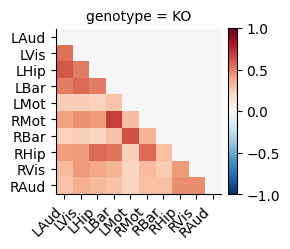

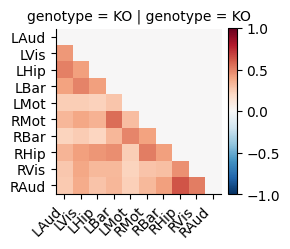

In [8]:
ep.plot_diffheatmap('cohere', ['animalday', 'genotype'], baseline_key=('A10 KO Dec-13-2023', 'KO'), average_groupby=True)
ep.plot_diffheatmap('cohere', ['animalday', 'genotype', 'isday'], baseline_key=(True, 'KO'), baseline_groupby=['isday', 'genotype'])
ep.plot_diffheatmap('cohere', 'animalday', baseline_key='A10 KO Dec-13-2023', remove_baseline=True)
ep.plot_heatmap('cohere', 'animalday')
g = ep.plot_heatmap('cohere', 'genotype')
display(g.data)
g= ep.plot_heatmap('cohere', ['animalday', 'genotype'], col='genotype', row=None, average_groupby=True)
display(g.data)


2025-04-10 17:42:12,914 - DEBUG - groups: [('A10', 'KO'), ('F22', 'KO')]
2025-04-10 17:42:12,915 - DEBUG - vals.shape: (31,)
2025-04-10 17:42:12,916 - DEBUG - vals.shape: (117,)


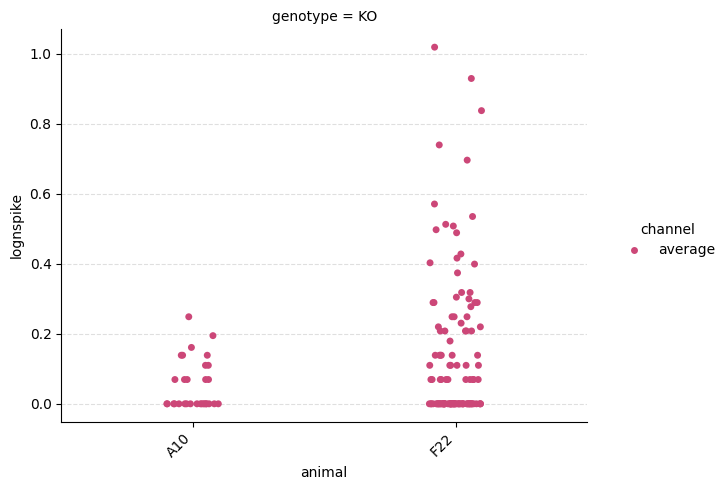

In [15]:
# ep.plot_catplot('cohere', ['animal', 'genotype'], collapse_channels=True, hue='band', stat_pairs=[[('F22', 'delta'), ('F22', 'theta')]])
# ep.plot_catplot('cohere', ['animal', 'genotype'], collapse_channels=True, hue='band', kind='point', stat_pairs=[[('F22', 'delta'), ('F22', 'theta')]], catplot_params={'errorbar': 'ci'})
# ep.plot_catplot('logampvar', ['animal', 'genotype'], x='genotype', kind='swarm', average_groupby=True, catplot_params={'dodge': True})
# ep.plot_catplot('logpsdfrac', ['animal', 'genotype'], collapse_channels=True, hue='band')
# ep.plot_catplot('logpsdfrac', ['isday', 'animalday'], hue='channel', x='animalday', col='band', cmap='viridis')
# ep.plot_catplot('logpsdband', ['animalday'], x='animalday', hue='band', cmap='viridis', average_groupby=True)
# ep.plot_catplot('lognspike', ['animal', 'genotype'], kind='point', cmap='plasma', catplot_params={'dodge': True})
ep.plot_catplot('lognspike', ['animal', 'genotype'], kind='strip', cmap='plasma', collapse_channels=True)